In [21]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.utils import img_to_array, load_img
from shutil import copyfile
from PIL import Image
%matplotlib inline

In [22]:
print(tf.__version__)

2.12.0


In [23]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>=0.94):
      self.model.stop_training = True

callbacks = myCallback()

In [24]:
# Resized gambar agar memiliku jumlah pixel yang sama
def copy_to_working(path, new_path):
    for dirname in os.listdir(path):
      for filename in os.scandir(os.path.join(path, dirname)):
        copyfile(os.path.join(path, dirname, filename.name), os.path.join(new_path, dirname, filename.name))

In [25]:
# Membuat fungsi untuk menyalin data dari sumber data ke train dan test dir seusai yang diinginkan

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TESTING_DIR, SPLIT_SIZE):
  all_files = []

  for file_name in os.listdir(SOURCE_DIR):
      file_path = SOURCE_DIR + file_name

      if os.path.getsize(file_path):
          all_files.append(file_name)
      else:
          print('{} is zero length, so ignoring'.format(file_name))

  train_val_size = int(SPLIT_SIZE * len(all_files))
  val_test_size = int(len(all_files) - int((len(all_files)-train_val_size)/2))
  shuffled = random.sample(all_files, len(all_files))
  train, val, test = shuffled[:train_val_size], shuffled[train_val_size:val_test_size], shuffled[val_test_size:]

  for filename in train:
    copyfile(SOURCE_DIR + filename, TRAINING_DIR + filename)

  for filename in val:
    copyfile(SOURCE_DIR + filename, VALIDATION_DIR + filename)

  for filename in test:
    copyfile(SOURCE_DIR + filename, TESTING_DIR + filename)

In [26]:
# Membuat direktori untuk menempatka data yang akan digunakan

root_dir = '/kaggle/working/coffee-leaf-diseases'
tmp_dir = '/kaggle/working/tmp'
source_dir = '/kaggle/input/coffee-disease/Coffee_Disease_Dataset'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

if os.path.exists(tmp_dir):
  shutil.rmtree(tmp_dir)

os.mkdir(tmp_dir)
os.mkdir(os.path.join(tmp_dir, 'cerscospora'))
os.mkdir(os.path.join(tmp_dir, 'miner'))
os.mkdir(os.path.join(tmp_dir, 'nodisease'))
os.mkdir(os.path.join(tmp_dir, 'phoma'))
os.mkdir(os.path.join(tmp_dir, 'rust'))

def create_train_test_dirs(root_path):
  os.mkdir(root_path)
  os.mkdir(os.path.join(root_path, 'train'))
  os.mkdir(os.path.join(root_path, 'val'))
  os.mkdir(os.path.join(root_path, 'test'))

  for foldername in os.listdir(os.path.join(source_dir)):
    for i in os.listdir(root_path):
      os.mkdir(os.path.join(root_path, i, foldername))

try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("File Sudah Ada")

In [27]:
# Lokasi Semua Dataset Utama
# Lokasi Dataset Tiap Penyakit
cerscospora_source = os.path.join(source_dir, 'cerscospora/')
healthy_source = os.path.join(source_dir, 'nodisease/')
miner_source = os.path.join(source_dir, 'miner/')
phoma_source = os.path.join(source_dir, 'phoma/')
rust_source = os.path.join(source_dir, 'rust/')

# Lokasi Dataset Tiap Penyakit
cerscospora_tmp = os.path.join(tmp_dir, 'cerscospora/')
healthy_tmp = os.path.join(tmp_dir, 'nodisease/')
miner_tmp = os.path.join(tmp_dir, 'miner/')
phoma_tmp = os.path.join(tmp_dir, 'phoma/')
rust_tmp = os.path.join(tmp_dir, 'rust/')

# Lokasi Utama Dataset Setelah Dibagi
train_dir = os.path.join(root_dir, 'train/')
val_dir = os.path.join(root_dir, 'val/')
test_dir = os.path.join(root_dir, 'test/')

# Lokasi Dataset Training Tiap Penyakit Setelah Di Bagi
train_cerscospora_dir = os.path.join(train_dir, 'cerscospora/')
train_healthty_dir = os.path.join(train_dir, 'nodisease/')
train_miner_dir = os.path.join(train_dir, 'miner/')
train_phoma_dir = os.path.join(train_dir, 'phoma/')
train_rust_dir = os.path.join(train_dir, 'rust/')

# Lokasi Dataset Validation Tiap Penyakit Setelah Di Bagi
val_cerscospora_dir = os.path.join(val_dir, 'cerscospora/')
val_healthty_dir = os.path.join(val_dir, 'nodisease/')
val_miner_dir = os.path.join(val_dir, 'miner/')
val_phoma_dir = os.path.join(val_dir, 'phoma/')
val_rust_dir = os.path.join(val_dir, 'rust/')

# Lokasi Dataset Testing Tiap Penyakit Setelah Di Bagi
test_cerscospora_dir = os.path.join(test_dir, 'cerscospora/')
test_healthty_dir = os.path.join(test_dir, 'nodisease/')
test_miner_dir = os.path.join(test_dir, 'miner/')
test_phoma_dir = os.path.join(test_dir, 'phoma/')
test_rust_dir = os.path.join(test_dir, 'rust/')

In [28]:
# Melihat contoh ukuran dataset
sample_image  = load_img('/kaggle/input/coffee-disease/Coffee_Disease_Dataset/miner/100.jpg')
sample_array = img_to_array(sample_image)
print(f"Each image has shape: {sample_array.shape}")

sample_image  = load_img('/kaggle/input/coffee-disease/Coffee_Disease_Dataset/cerscospora/12088928264_a953dbfae1_b.jpg')
sample_array = img_to_array(sample_image)
print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (1024, 2048, 3)
Each image has shape: (626, 847, 3)


In [29]:
copy_to_working(source_dir, tmp_dir)

In [30]:
# # Jumlah gambar yang ingin tersisa di setiap folder
# jumlah_tersisa = 3000

# for folder in os.listdir(tmp_dir):
#     # Dapatkan daftar semua file gambar dalam folder
#     gambar = [file for file in os.listdir(os.path.join(tmp_dir, folder)) if file.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

#     # Pastikan jumlah gambar yang ingin tersisa tidak melebihi jumlah gambar yang ada
#     jumlah_tersisa = min(jumlah_tersisa, len(gambar))

#     # Jumlah gambar yang akan dihapus
#     jumlah_hapus = len(gambar) - jumlah_tersisa

#     # Acak urutan gambar
#     random.shuffle(gambar)

#     # Hapus gambar secara acak sampai tersisa jumlah tertentu
#     for i in range(jumlah_hapus):
#         file = os.path.join(tmp_dir, folder, gambar[i])
#         os.remove(file)

# print('Penghapusan selesai.')

In [31]:
file_count = len([f for f in os.listdir("/kaggle/working/tmp/rust") if os.path.isfile(os.path.join("/kaggle/working/tmp/rust", f))])
print(f"Jumlah file dalam folder Leaf Rust: {file_count}")
file_count = len([f for f in os.listdir("/kaggle/working/tmp/cerscospora") if os.path.isfile(os.path.join("/kaggle/working/tmp/cerscospora", f))])
print(f"Jumlah file dalam folder Cerscospora: {file_count}")
file_count = len([f for f in os.listdir("/kaggle/working/tmp/miner") if os.path.isfile(os.path.join("/kaggle/working/tmp/miner", f))])
print(f"Jumlah file dalam folder Miner: {file_count}")
file_count = len([f for f in os.listdir("/kaggle/working/tmp/phoma") if os.path.isfile(os.path.join("/kaggle/working/tmp/phoma", f))])
print(f"Jumlah file dalam folder Phoma: {file_count}")
file_count = len([f for f in os.listdir("/kaggle/working/tmp/nodisease") if os.path.isfile(os.path.join("/kaggle/working/tmp/nodisease", f))])
print(f"Jumlah file dalam folder Healthy: {file_count}")

Jumlah file dalam folder Leaf Rust: 340
Jumlah file dalam folder Cerscospora: 335
Jumlah file dalam folder Miner: 492
Jumlah file dalam folder Phoma: 492
Jumlah file dalam folder Healthy: 427


In [32]:
# Pisahkan dan salin data mengguakan fungsi split_data
split_size = .6

split_data(cerscospora_tmp, train_cerscospora_dir, val_cerscospora_dir, test_cerscospora_dir, split_size)
split_data(healthy_tmp, train_healthty_dir, val_healthty_dir, test_healthty_dir, split_size)
split_data(miner_tmp, train_miner_dir, val_miner_dir, test_miner_dir, split_size)
split_data(phoma_tmp, train_phoma_dir, val_phoma_dir, test_phoma_dir, split_size)
split_data(rust_tmp, train_rust_dir, val_rust_dir, test_rust_dir, split_size)

In [33]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tentukan path folder train dan test
train_dir = '/kaggle/working/coffee-leaf-diseases/train'
val_dir = '/kaggle/working/coffee-leaf-diseases/val'
test_dir = '/kaggle/working/coffee-leaf-diseases/test'

# Load dataset train menjadi array numpy
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []
classes = ['cerscospora', 'nodisease', 'miner', 'phoma', 'rust']
for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((300, 150), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        train_images.append(image_array)
        train_labels.append(class_index)
    class_dir = os.path.join(val_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((300, 150), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        val_images.append(image_array)
        val_labels.append(class_index)
    class_dir = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((300, 150), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        test_images.append(image_array)
        test_labels.append(class_index)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Konversi dataset train menjadi tf.constant
train_images = tf.constant(np.squeeze(train_images), dtype=tf.float32)
train_labels = tf.constant(train_labels, dtype=tf.int32)
val_images = tf.constant(np.squeeze(val_images), dtype=tf.float32)
val_labels = tf.constant(val_labels, dtype=tf.int32)
test_images = tf.constant(np.squeeze(test_images), dtype=tf.float32)
test_labels = tf.constant(test_labels, dtype=tf.int32)

In [34]:
# Buat model untuk melatih data
EfficientNet = EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=(150, 300, 3),
)

for layer in EfficientNet.layers:
    layer.trainable = False
    
# start = EfficientNet.get_layer('block4c_add')


x = tf.keras.layers.Flatten()(EfficientNet.output)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model = Model(EfficientNet.input, x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 150, 300, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 150, 300, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

# Model with Learning Rate 1e-4

In [35]:
history = model.fit(train_images,
                    train_labels,
                    epochs=25,
                    verbose=1,
                    validation_data=(val_images, val_labels)
                   )

Epoch 1/25


2023-08-13 19:59:09.287000: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 20s 208ms/step - loss: 0.9257 - accuracy: 0.6491 - val_loss: 0.4197 - val_accuracy: 0.8401
Epoch 2/25
40/40 [==============================] - 6s 140ms/step - loss: 0.2979 - accuracy: 0.9009 - val_loss: 0.3027 - val_accuracy: 0.8926
Epoch 3/25
40/40 [==============================] - 7s 170ms/step - loss: 0.1985 - accuracy: 0.9488 - val_loss: 0.3043 - val_accuracy: 0.8711
Epoch 4/25
40/40 [==============================] - 6s 141ms/step - loss: 0.1779 - accuracy: 0.9432 - val_loss: 0.3068 - val_accuracy: 0.8878
Epoch 5/25
40/40 [==============================] - 7s 170ms/step - loss: 0.1422 - accuracy: 0.9552 - val_loss: 0.2186 - val_accuracy: 0.9189
Epoch 6/25
40/40 [==============================] - 6s 140ms/step - loss: 0.0988 - accuracy: 0.9784 - val_loss: 0.2169 - val_accuracy: 0.9117
Epoch 7/25
40/40 [==============================] - 7s 173ms/step - loss: 0.0936 - accuracy: 0.9736 - val_loss: 0.2509 - val_accuracy: 0.8950
Epoch 8/25
40/40

In [36]:
model.evaluate(test_images, test_labels)

13/13 [==============================] - 1s 107ms/step - loss: 0.1483 - accuracy: 0.9495


[0.14830419421195984, 0.9495192170143127]

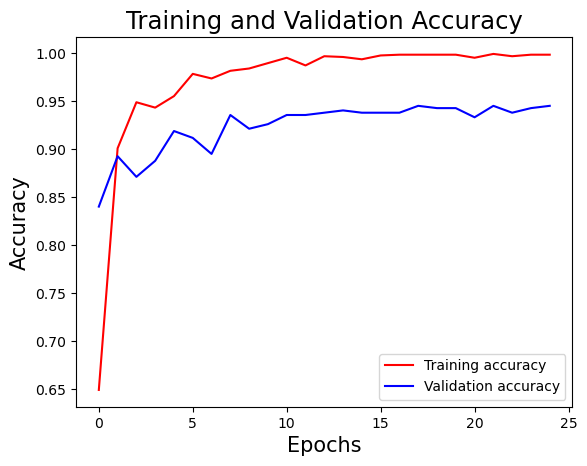

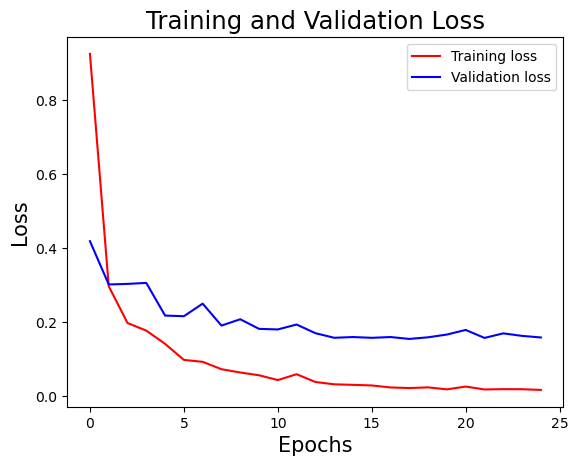

13/13 [==============================] - 4s 104ms/step


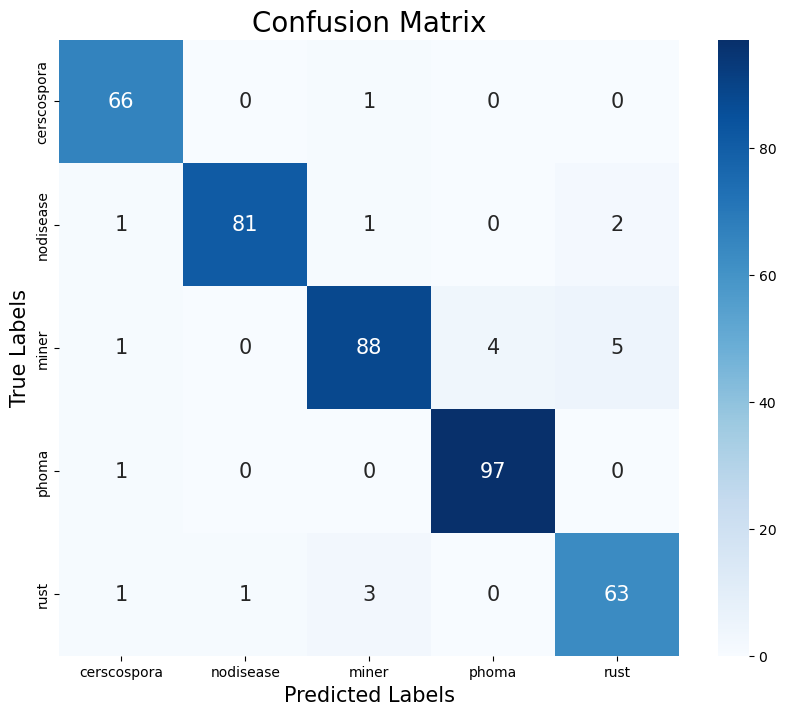

In [37]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Train and Validation Accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Accuracy", size=15)
plt.savefig('Accuracy_lr_1e-4.png')
plt.show()

#Train and Validation Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Loss", size=15)
plt.savefig('Loss_lr_1e-4.png')
plt.show()

# Confusion Matrix Heatmap
# class_labels = sorted(os.listdir('/kaggle/input/coffee-leaf-diseases/train'))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
# true_labels = val_generator.classes
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={'size': 15})
plt.xlabel('Predicted Labels', size=15)
plt.ylabel('True Labels', size=15)
plt.title('Confusion Matrix', size=20)
plt.savefig('Confusion Matrix_lr_1e-4.png')
plt.show()

In [38]:
import pandas as pd
pd.DataFrame({
    'acc': acc,
    'val_acc': val_acc,
    'loss': loss,
    'val_loss': val_loss,
})

,acc,val_acc,loss,val_loss
0,0.649081,0.840095,0.925726,0.419678
1,0.900879,0.892601,0.297904,0.302693
2,0.948841,0.871122,0.198459,0.304267
3,0.943245,0.887828,0.177944,0.306837
4,0.955236,0.918854,0.142176,0.218639
5,0.978417,0.911695,0.098845,0.216928
6,0.973621,0.894988,0.093605,0.250868
7,0.981615,0.935561,0.073684,0.191590
8,0.984013,0.921241,0.064811,0.208703
9,0.989608,0.926014,0.057291,0.182724


In [39]:
prediksi = model.predict(test_images)
y_pred = np.argmax(prediksi, axis=1)
# y_true = val_generator.labels

print(classification_report(test_labels, y_pred))

13/13 [==============================] - 1s 101ms/step
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        67
           1       0.99      0.95      0.97        85
           2       0.95      0.90      0.92        98
           3       0.96      0.99      0.97        98
           4       0.90      0.93      0.91        68

    accuracy                           0.95       416
   macro avg       0.95      0.95      0.95       416
weighted avg       0.95      0.95      0.95       416



In [40]:
# Save model dengan format Protobuf
tf.saved_model.save(model, "/kaggle/working/Model")
my_model = tf.saved_model.load('/kaggle/working/Model')

# convert model ke TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

# save TFLite model
with open('Coffee_disease_EfficientNetB3_lr_1e-4.tflite', 'wb') as f:
  f.write(tflite_model)

# Model with Learning Rate 5e-4

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
history = model.fit(train_images,
                    train_labels,
                    epochs=25,
                    verbose=1,
                    validation_data=(val_images, val_labels)
                   )

Epoch 1/25


2023-08-13 20:04:25.156414: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 20s 231ms/step - loss: 0.4464 - accuracy: 0.8753 - val_loss: 0.2789 - val_accuracy: 0.9117
Epoch 2/25
40/40 [==============================] - 7s 169ms/step - loss: 0.1969 - accuracy: 0.9464 - val_loss: 0.2818 - val_accuracy: 0.9045
Epoch 3/25
40/40 [==============================] - 6s 139ms/step - loss: 0.0420 - accuracy: 0.9816 - val_loss: 0.2510 - val_accuracy: 0.9189
Epoch 4/25
40/40 [==============================] - 7s 170ms/step - loss: 0.0577 - accuracy: 0.9848 - val_loss: 0.4349 - val_accuracy: 0.9189
Epoch 5/25
40/40 [==============================] - 6s 140ms/step - loss: 0.0448 - accuracy: 0.9832 - val_loss: 0.4680 - val_accuracy: 0.9165
Epoch 6/25
40/40 [==============================] - 6s 140ms/step - loss: 0.0341 - accuracy: 0.9896 - val_loss: 0.5695 - val_accuracy: 0.8998
Epoch 7/25
40/40 [==============================] - 7s 172ms/step - loss: 0.0656 - accuracy: 0.9808 - val_loss: 0.3736 - val_accuracy: 0.9165
Epoch 8/25
40/40

In [43]:
model.evaluate(test_images, test_labels)

13/13 [==============================] - 1s 108ms/step - loss: 0.3192 - accuracy: 0.9495


[0.3192315697669983, 0.9495192170143127]

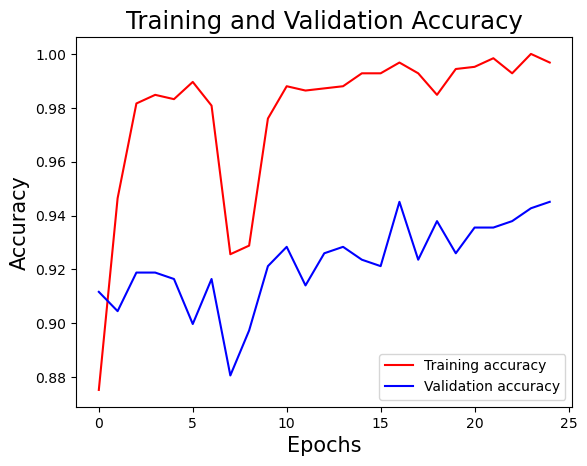

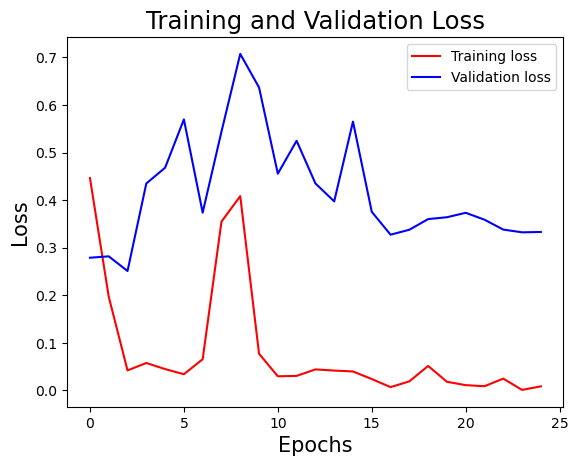

13/13 [==============================] - 4s 105ms/step


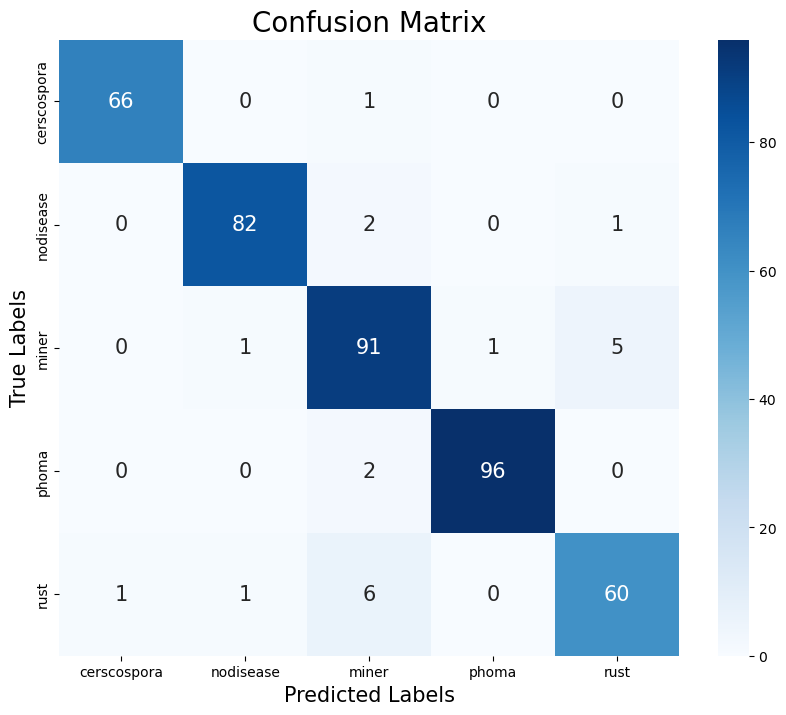

In [44]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Train and Validation Accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Accuracy", size=15)
plt.savefig('Accuracy_lr_5e-4.png')
plt.show()

#Train and Validation Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Loss", size=15)
plt.savefig('Loss_lr_5e-4.png')
plt.show()

# Confusion Matrix Heatmap
# class_labels = sorted(os.listdir('/kaggle/input/coffee-leaf-diseases/train'))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
# true_labels = val_generator.classes
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={'size': 15})
plt.xlabel('Predicted Labels', size=15)
plt.ylabel('True Labels', size=15)
plt.title('Confusion Matrix', size=20)
plt.savefig('Confusion Matrix_lr_5e-4.png')
plt.show()

In [45]:
import pandas as pd
pd.DataFrame({
    'acc': acc,
    'val_acc': val_acc,
    'loss': loss,
    'val_loss': val_loss,
})

,acc,val_acc,loss,val_loss
0,0.875300,0.911695,0.446434,0.278860
1,0.946443,0.904535,0.196922,0.281788
2,0.981615,0.918854,0.042004,0.250986
3,0.984812,0.918854,0.057678,0.434903
4,0.983213,0.916468,0.044829,0.468020
5,0.989608,0.899761,0.034067,0.569544
6,0.980815,0.916468,0.065602,0.373641
7,0.925659,0.880668,0.354668,0.543806
8,0.928857,0.897375,0.408249,0.707166
9,0.976019,0.921241,0.077178,0.636687


In [46]:
prediksi = model.predict(test_images)
y_pred = np.argmax(prediksi, axis=1)
# y_true = val_generator.labels

print(classification_report(test_labels, y_pred))

13/13 [==============================] - 1s 98ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        67
           1       0.98      0.96      0.97        85
           2       0.89      0.93      0.91        98
           3       0.99      0.98      0.98        98
           4       0.91      0.88      0.90        68

    accuracy                           0.95       416
   macro avg       0.95      0.95      0.95       416
weighted avg       0.95      0.95      0.95       416



In [47]:
# Save model dengan format Protobuf
tf.saved_model.save(model, "/kaggle/working/Model")
my_model = tf.saved_model.load('/kaggle/working/Model')

# convert model ke TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

# save TFLite model
with open('Coffee_disease_EfficientNetB3_lr_5e-4.tflite', 'wb') as f:
  f.write(tflite_model)

# Model with Learning Rate 1e-3

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
history = model.fit(train_images,
                    train_labels,
                    epochs=25,
                    verbose=1,
                    validation_data=(val_images, val_labels)
                   )

Epoch 1/25


2023-08-13 20:10:36.734962: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 19s 202ms/step - loss: 0.1987 - accuracy: 0.9520 - val_loss: 0.9985 - val_accuracy: 0.8735
Epoch 2/25
40/40 [==============================] - 7s 169ms/step - loss: 0.1111 - accuracy: 0.9784 - val_loss: 0.4708 - val_accuracy: 0.9236
Epoch 3/25
40/40 [==============================] - 5s 138ms/step - loss: 0.2099 - accuracy: 0.9616 - val_loss: 1.1204 - val_accuracy: 0.8616
Epoch 4/25
40/40 [==============================] - 6s 138ms/step - loss: 0.1242 - accuracy: 0.9768 - val_loss: 0.6928 - val_accuracy: 0.9165
Epoch 5/25
40/40 [==============================] - 6s 139ms/step - loss: 0.0274 - accuracy: 0.9912 - val_loss: 0.7333 - val_accuracy: 0.9189
Epoch 6/25
40/40 [==============================] - 7s 170ms/step - loss: 0.0744 - accuracy: 0.9880 - val_loss: 0.9641 - val_accuracy: 0.9045
Epoch 7/25
40/40 [==============================] - 6s 140ms/step - loss: 0.0691 - accuracy: 0.9848 - val_loss: 0.9313 - val_accuracy: 0.9045
Epoch 8/25
40/40

In [50]:
model.evaluate(test_images, test_labels)

13/13 [==============================] - 1s 108ms/step - loss: 1.0602 - accuracy: 0.9399


[1.0602468252182007, 0.9399038553237915]

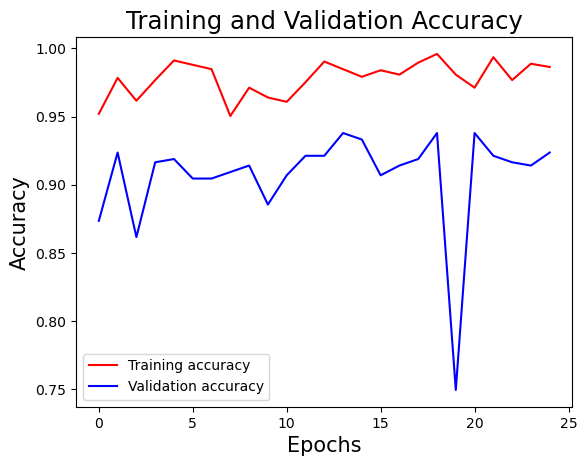

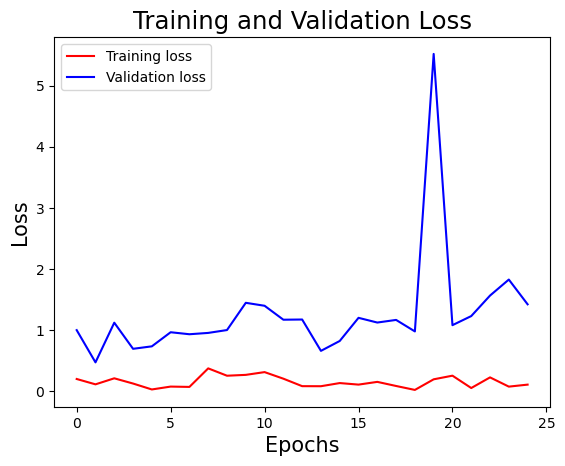

13/13 [==============================] - 4s 105ms/step


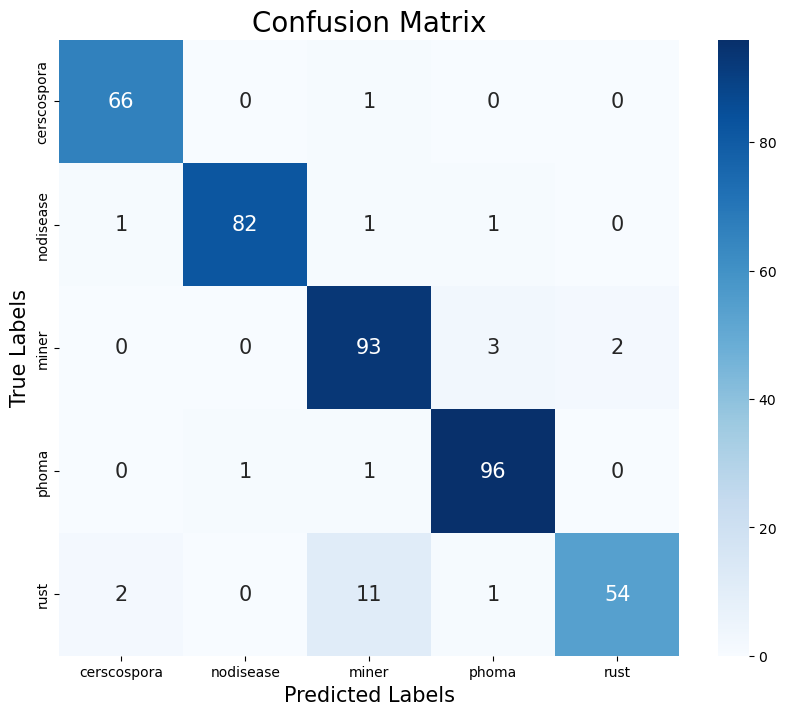

In [51]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Train and Validation Accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Accuracy", size=15)
plt.savefig('Accuracy_lr_1e-3.png')
plt.show()

#Train and Validation Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Loss", size=15)
plt.savefig('Loss_lr_1e-3.png')
plt.show()

# Confusion Matrix Heatmap
# class_labels = sorted(os.listdir('/kaggle/input/coffee-leaf-diseases/train'))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
# true_labels = val_generator.classes
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={'size': 15})
plt.xlabel('Predicted Labels', size=15)
plt.ylabel('True Labels', size=15)
plt.title('Confusion Matrix', size=20)
plt.savefig('Confusion Matrix_lr_1e-3.png')
plt.show()

In [52]:
import pandas as pd
pd.DataFrame({
    'acc': acc,
    'val_acc': val_acc,
    'loss': loss,
    'val_loss': val_loss,
})

,acc,val_acc,loss,val_loss
0,0.952038,0.873508,0.198689,0.998524
1,0.978417,0.923628,0.111069,0.470801
2,0.961631,0.861575,0.209893,1.120382
3,0.976819,0.916468,0.124223,0.692807
4,0.991207,0.918854,0.027381,0.733279
5,0.988010,0.904535,0.074367,0.964067
6,0.984812,0.904535,0.069081,0.931266
7,0.950440,0.909308,0.372561,0.953069
8,0.971223,0.914081,0.252207,0.999940
9,0.964029,0.885442,0.266227,1.445830


In [53]:
prediksi = model.predict(test_images)
y_pred = np.argmax(prediksi, axis=1)
# y_true = val_generator.labels

print(classification_report(test_labels, y_pred))

13/13 [==============================] - 1s 99ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        67
           1       0.99      0.96      0.98        85
           2       0.87      0.95      0.91        98
           3       0.95      0.98      0.96        98
           4       0.96      0.79      0.87        68

    accuracy                           0.94       416
   macro avg       0.95      0.93      0.94       416
weighted avg       0.94      0.94      0.94       416



In [54]:
# Save model dengan format Protobuf
tf.saved_model.save(model, "/kaggle/working/Model")
my_model = tf.saved_model.load('/kaggle/working/Model')

# convert model ke TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

# save TFLite model
with open('Coffee_disease_EfficientNetB3_lr_1e-3.tflite', 'wb') as f:
  f.write(tflite_model)

In [55]:
print("Train")
print("Cerscospora:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/cerscospora")))
print("No Disease:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/nodisease")))
print("Miner:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/miner")))
print("Phoma:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/phoma")))
print("Rust:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/rust")))

print("\nVal")
print("Cerscospora:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/cerscospora")))
print("No Disease:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/nodisease")))
print("Miner:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/miner")))
print("Phoma:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/phoma")))
print("Rust:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/rust")))

print("\nTest")
print("Cerscospora:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/cerscospora")))
print("No Disease:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/nodisease")))
print("Miner:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/miner")))
print("Phoma:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/phoma")))
print("Rust:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/rust")))

Train
Cerscospora: 201
No Disease: 256
Miner: 295
Phoma: 295
Rust: 204

Val
Cerscospora: 67
No Disease: 86
Miner: 99
Phoma: 99
Rust: 68

Test
Cerscospora: 67
No Disease: 85
Miner: 98
Phoma: 98
Rust: 68
